In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Dropout, Flatten, TimeDistributed,Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, RepeatVector, Permute, Multiply
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D 

import torch
import torchaudio
import pandas as pd
import numpy as np
from scipy.io import wavfile
from scipy import signal
import io
import os
import tarfile
import tempfile
import librosa
import librosa.display
import sklearn
import random
import itertools

import matplotlib.pyplot as plt
import requests
from IPython.display import Audio
from torchaudio.utils import download_asset

from scipy.signal import lfilter
import csv
import wave
import struct
import statistics
from datetime import datetime

심음 데이터셋 출력

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/Heart_sound.xlsx')
dataset

,file_name,diagnosis
0,extrasystole1.wav,extrasystole
1,extrasystole2.wav,extrasystole
2,extrasystole3.wav,extrasystole
3,extrasystole4.wav,extrasystole
4,extrasystole5.wav,extrasystole
...,...,...
307,normal196.wav,normal
308,normal197.wav,normal
309,normal198.wav,normal
310,normal199.wav,normal


In [ ]:
data_list = dataset['file_name'].tolist()
data_list

['extrasystole1.wav',
 'extrasystole2.wav',
 'extrasystole3.wav',
 'extrasystole4.wav',
 'extrasystole5.wav',
 'extrasystole6.wav',
 'extrasystole7.wav',
 'extrasystole8.wav',
 'extrasystole9.wav',
 'extrasystole10.wav',
 'extrasystole11.wav',
 'extrasystole12.wav',
 'extrasystole13.wav',
 'extrasystole14.wav',
 'extrasystole15.wav',
 'extrasystole16.wav',
 'extrasystole17.wav',
 'extrasystole18.wav',
 'extrasystole19.wav',
 'extrasystole20.wav',
 'extrasystole21.wav',
 'extrasystole22.wav',
 'extrasystole23.wav',
 'extrasystole24.wav',
 'extrasystole25.wav',
 'extrasystole26.wav',
 'extrasystole27.wav',
 'extrasystole28.wav',
 'extrasystole29.wav',
 'extrasystole30.wav',
 'extrasystole31.wav',
 'extrasystole32.wav',
 'extrasystole33.wav',
 'extrasystole34.wav',
 'extrasystole35.wav',
 'extrasystole36.wav',
 'extrasystole37.wav',
 'extrasystole38.wav',
 'extrasystole39.wav',
 'extrasystole40.wav',
 'extrasystole41.wav',
 'extrasystole42.wav',
 'extrasystole43.wav',
 'extrasystole44.wav

심음 waveform 출력

In [ ]:
wav, sr = librosa.load('/content/drive/MyDrive/Heart_sound/'+'murmur1.wav', sr = None)
rsr = sr*2 
print('sr:',sr)
print('wav shape:', wav.shape)
print('length:',wav.shape[0]/float(sr), 'secs')
print('rsr:',rsr)

sr: 4000
wav shape: (18665,)
length: 4.66625 secs
rsr: 8000


Text(0.5, 1.0, 'Waveform')

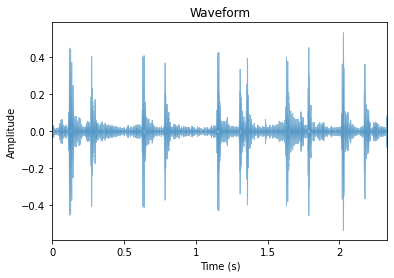

In [ ]:
librosa.display.waveplot(wav, rsr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

진단명 index 부가

In [ ]:
dataset.loc[dataset['diagnosis'] == 'extrasystole', 'diagnosis_num'] = 0
dataset.loc[dataset['diagnosis'] == 'murmur', 'diagnosis_num'] = 1
dataset.loc[dataset['diagnosis'] == 'normal', 'diagnosis_num'] = 2

In [ ]:
murmur = dataset[dataset.diagnosis == 'murmur'].index.tolist()
normal = dataset[dataset.diagnosis == 'normal'].index.tolist()
extrastole = dataset[dataset.diagnosis == 'extrastole'].index.tolist()

데이터 추가

In [ ]:
length_extrasystole = len(dataset[dataset['diagnosis']== 'extrasystole'])
length_murmur = len(dataset[dataset['diagnosis']== 'murmur'])
length_normal = len(dataset[dataset['diagnosis']== 'normal'])

In [ ]:
for i in range(300-length_extrasystole):
  dataset = dataset.append(dataset[dataset['diagnosis']=='extrasystole'].iloc[random.randrange(0,length_extrasystole)], ignore_index = True)


for i in range(300-length_murmur):
  dataset = dataset.append(dataset[dataset['diagnosis']=='murmur'].iloc[random.randrange(0,length_murmur)], ignore_index = True)

for i in range(300-length_normal):
  dataset = dataset.append(dataset[dataset['diagnosis']=='normal'].iloc[random.randrange(0,length_normal)], ignore_index = True)
dataset

,file_name,diagnosis,diagnosis_num
0,extrasystole1.wav,extrasystole,0.0
1,extrasystole2.wav,extrasystole,0.0
2,extrasystole3.wav,extrasystole,0.0
3,extrasystole4.wav,extrasystole,0.0
4,extrasystole5.wav,extrasystole,0.0
...,...,...,...
895,normal37.wav,normal,2.0
896,normal36.wav,normal,2.0
897,normal169.wav,normal,2.0
898,normal186.wav,normal,2.0


데이터 랜덤하게 섞기

In [ ]:
dataset_shuffled = dataset.iloc[np.random.permutation(dataset.index)].reset_index(drop=True)
print(dataset_shuffled)

              file_name     diagnosis  diagnosis_num
0           murmur8.wav        murmur            1.0
1           murmur4.wav        murmur            1.0
2          normal85.wav        normal            2.0
3          murmur45.wav        murmur            1.0
4    extrasystole10.wav  extrasystole            0.0
..                  ...           ...            ...
895  extrasystole25.wav  extrasystole            0.0
896   extrasystole9.wav  extrasystole            0.0
897        murmur57.wav        murmur            1.0
898  extrasystole33.wav  extrasystole            0.0
899       normal116.wav        normal            2.0

[900 rows x 3 columns]


CNN모델 생성

In [ ]:
pad2d = lambda a,i: a[:,0:i] if a.shape[1] >i else np.hstack((a,np.zeros((a.shape[0],i-a.shape[1]))))

In [ ]:
wav,sr = librosa.load('/content/drive/MyDrive/Heart_sound/'+dataset_shuffled['file_name'][15])

In [ ]:
mfcc = librosa.feature.mfcc(wav)

In [ ]:
padded_mfcc = pad2d(mfcc,40)

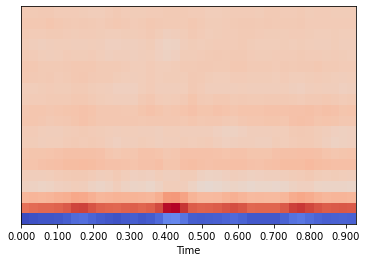

In [ ]:
librosa.display.specshow(padded_mfcc, sr=sr, x_axis='time')

In [ ]:
 
 x_train = []
mfccs_train = []
y_train = []

x_test = []
mfccs_test = []
y_test = []

pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a,i: a[:,0:i] if a.shape[1] >i else np.hstack((a,np.zeros((a.shape[0],i-a.shape[1]))))

for i in range(len(dataset_shuffled['file_name'])):
  wav,sr = librosa.load('/content/drive/MyDrive/Heart_sound/'+dataset_shuffled['file_name'][i])
  padded_x = pad1d(wav,10000)
  mfcc = librosa.feature.mfcc(wav)
  padded_mfcc = pad2d(mfcc,40)

  if i <= (len(dataset_shuffled['file_name']) * 0.8 -1):
    x_train.append(padded_x)
    mfccs_train.append(padded_mfcc)
    y_train.append(dataset_shuffled['diagnosis_num'][i])

  else:
    x_test.append(padded_x)
    mfccs_test.append(padded_mfcc)
    y_test.append(dataset_shuffled['diagnosis_num'][i])

In [ ]:
x_train = np.vstack(x_train)
mfccs_train = np.array(mfccs_train)
y_train_array = np.array(y_train)

x_test = np.vstack(x_test)
mfccs_test = np.array(mfccs_test)
y_test_array = np.array(y_test)

print('x_train:', x_train.shape)
print('mfccs_train:', mfccs_train.shape)
print('y_train:', y_train_array.shape)

print('x_test:', x_test.shape)
print('mfccs_test:', mfccs_test.shape)
print('y_test:', y_test_array.shape)

x_train: (720, 10000)
mfccs_train: (720, 20, 40)
y_train: (720,)
x_test: (180, 10000)
mfccs_test: (180, 20, 40)
y_test: (180,)


In [ ]:
x_train_ex = np.expand_dims(mfccs_train,-1)
x_test_ex = np.expand_dims(mfccs_test,-1)
print('x train shape:', x_train_ex.shape)
print('x test shape:', x_test_ex.shape)

x train shape: (720, 20, 40, 1)
x test shape: (180, 20, 40, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 40, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 37, 512)       8704      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 9, 512)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

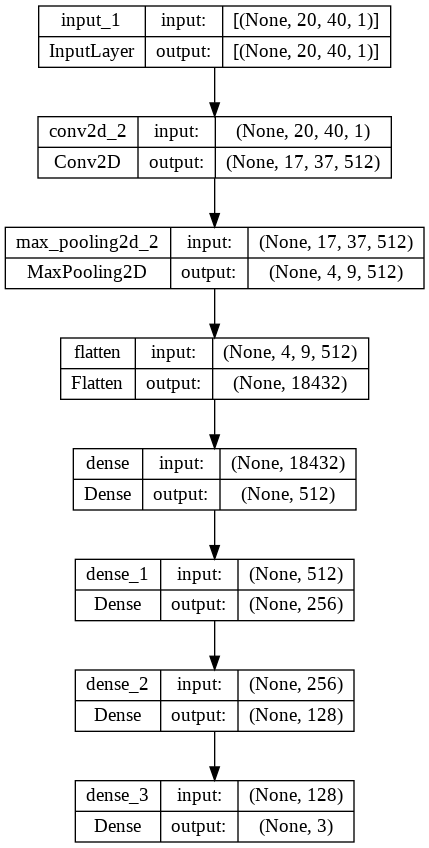

In [ ]:
ip = Input(shape = (x_train_ex[0].shape))

m = Conv2D(128,kernel_size = (4,4),activation = 'relu')(ip)
m = MaxPooling2D(pool_size = (4,4))(m)

m = Conv2D(256,kernel_size = (4,4),activation = 'relu')(ip)
m = MaxPooling2D(pool_size = (4,4))(m)

m = Conv2D(512,kernel_size = (4,4),activation = 'relu')(ip)
m = MaxPooling2D(pool_size = (4,4))(m)

m = Flatten()(m)
m = Dense(512,activation = 'relu')(m)
m = Dense(256,activation = 'relu')(m)
m = Dense(128,activation = 'relu')(m)

op = Dense(3, activation = 'softmax')(m)

model = tf.keras.Model(ip,op)
model.summary()
tf.keras.utils.plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(x_train_ex, y_train_array, epochs = 30, batch_size = 128,verbose = 1)

Epoch 1/30
6/6 [==============================] - 5s 608ms/step - loss: 39.4663 - accuracy: 0.3250
Epoch 2/30
6/6 [==============================] - 4s 588ms/step - loss: 6.4643 - accuracy: 0.3583
Epoch 3/30
6/6 [==============================] - 4s 574ms/step - loss: 3.6096 - accuracy: 0.3486
Epoch 4/30
6/6 [==============================] - 4s 577ms/step - loss: 1.7300 - accuracy: 0.3972
Epoch 5/30
6/6 [==============================] - 4s 581ms/step - loss: 1.0332 - accuracy: 0.4972
Epoch 6/30
6/6 [==============================] - 3s 568ms/step - loss: 0.8798 - accuracy: 0.5708
Epoch 7/30
6/6 [==============================] - 3s 555ms/step - loss: 0.8334 - accuracy: 0.6028
Epoch 8/30
6/6 [==============================] - 3s 562ms/step - loss: 0.7854 - accuracy: 0.6333
Epoch 9/30
6/6 [==============================] - 3s 568ms/step - loss: 0.7146 - accuracy: 0.6708
Epoch 10/30
6/6 [==============================] - 3s 563ms/step - loss: 0.6849 - accuracy: 0.7042
Epoch 11/30
6/6 [=

In [ ]:
score = model.evaluate(x_test_ex, y_test_array, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3780592083930969
Test accuracy: 0.9277777671813965


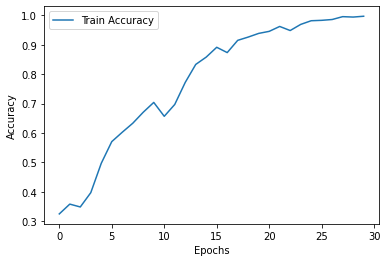

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
    	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
      
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    	plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

6/6 [==============================] - 0s 39ms/step


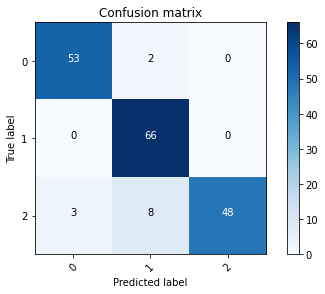

In [ ]:
Y_pred = model.predict(x_test_ex)

Y_pred_classes = np.argmax(Y_pred, axis = -1)

Y_true = y_test_array

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
# Y_true = []
# Y_pred_classes = []

In [ ]:
# for i in range(64):
#   Y_true.append(2)

In [ ]:
# for i in range(55):
#   Y_pred_classes.append(2)

In [ ]:
# A = [[100,0,0],[0,100,0],[4.7,9.4,86]]
# A = np.array(A)

In [ ]:
# plt.imshow(A, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion matrix')
# plt.colorbar()
# tick_marks=[0,1,2]
# plt.xticks(tick_marks, range(3), rotation=45)
# plt.yticks(tick_marks, range(3))

    
# thresh = A.max() / 2
# for i, j in itertools.product(range(A.shape[0]), range(A.shape[1])):
#   plt.text(j, i, A[i, j], horizontalalignment="center", color="white" if A[i, j] > thresh else "black")
    
# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')

하드웨어로 받은 값에 적용

In [ ]:
filenames = ["/content/drive/MyDrive/CoolTerm Capture 2022-09-20 00-09-54.csv"] 
properties = ['Amplitude' for f in filenames] 
f = 120 # sampling frequency

In [ ]:
#wav파일 생성
for filename, property in zip(filenames, properties):
	data = [value for time, value in csv.reader(open(filename, 'U'), delimiter=',')]

	for i in reversed(range(len(data))):
		try: a = float(data[i])
		except: del(data[i])

	data = [float(d) for d in data]

	data = [(d-sum(data)/len(data))/abs(max(data)) for d in data]

	saturation = 3*statistics.pstdev(data)
	data = [d/saturation if abs(d) < saturation else d/abs(d) for d in data]

	wavfilename = filename + '_' + str(datetime.now().strftime('%Y%m%d_%H%M%S')) + property + '.wav'
	wavfile = wave.open(wavfilename, 'w')


	wavfile.setparams((1,2,f, len(data), 'NONE', 'not compressed'))

	data_bytes = b''.join([struct.pack('<h', int(d*1024*24)) for d in data])

	wavfile.writeframes(data_bytes)
	wavfile.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
wav, sr = librosa.load(wavfilename, sr = None)

print(wavfilename)
print('sr:',sr)
print('wav shape:', wav.shape)
print('length:',wav.shape[0]/float(sr), 'secs')

/content/drive/MyDrive/CoolTerm Capture 2022-09-20 00-09-54.csv_20221028_082616Amplitude.wav
sr: 120
wav shape: (901,)
length: 7.508333333333334 secs


Text(0.5, 1.0, 'Waveform')

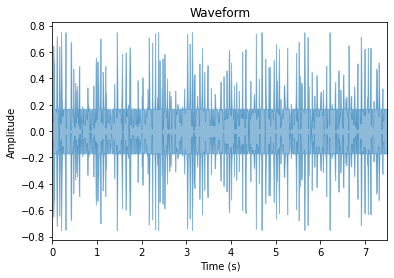

In [ ]:
librosa.display.waveplot(wav, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [ ]:
print(sr)

120


노이즈 제거

Text(0.5, 1.0, 'Waveform')

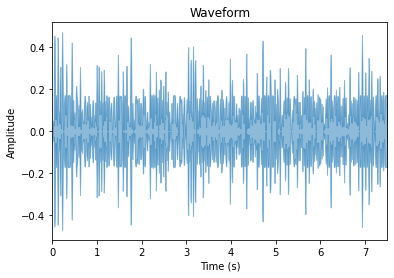

In [ ]:
nyquist = sr/2
lower_filter_bound = 20
upper_filter_bound = 300
filter_order = int(np.round((sr/lower_filter_bound)))

lower = lower_filter_bound/nyquist
upper = upper_filter_bound/nyquist

b = signal.firwin(filter_order, [lower, upper], pass_zero=False,  fs = sr)
wav1 = lfilter(b,[1,0], wav)

librosa.display.waveplot(wav1, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

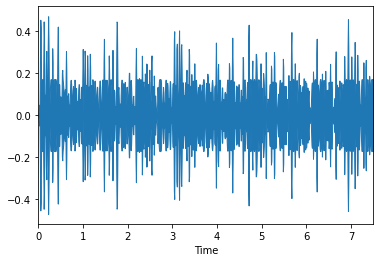

In [ ]:
librosa.display.waveplot(wav1, sr)

만든 모델에 적용

In [ ]:
x = []
mfccs_input = []

pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a,i: a[:,0:i] if a.shape[1] >i else np.hstack((a,np.zeros((a.shape[0],i-a.shape[1]))))

padded_x = pad1d(wav1,10000)
mfcc = librosa.feature.mfcc(wav1,sr)
padded_mfcc = pad2d(mfcc,40)

x.append(padded_x)
mfccs_input.append(padded_mfcc)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=901
  n_fft, y.shape[-1]


In [ ]:
x_ex = np.expand_dims(mfccs_input,-1)

In [ ]:
y_output = model.predict(x_ex, verbose=0) 
y = y_output.argmax(axis=-1)
y

array([1])

In [ ]:
y = [2]

In [ ]:
if y[0] == 0:
  print('반복되면 병원에 방문해주세요')
elif y[0] == 1:
  print('빠르게 병원에 방문해주세요')
else:print('정상입니다')

정상입니다


In [ ]:
# #모델 저장
import pickle 
with open('/content/drive/MyDrive/KOLOK-E.pickle','wb') as fw:
    pickle.dump(model, fw)

In [ ]:
# 모델 읽어올 때
# import pickle 
# with open('model_210519.pickle', 'rb') as f: 
#     model = pickle.load(f)
# ​
